# Matrix Profile Example
## 2018 NYC Yellow Taxi Passengers

In this example, we use the STOMP algorithm to perform both data mining and exploratory analysis tasks. STOMP is an exact algorithm; meaning that it will not give an approximate solution. The data set is composed of aggregated passenger counts for yellow taxi cabs in NYC during the year 2018. If you are interested in learning more about the original data, please refer to the "NYC Taxi 2018 Aggregation" notebook.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from matrixprofile.matrixProfile import stomp
from matrixprofile.motifs import motifs
from matrixprofile.discords import discords

%matplotlib inline

/home/tmarrs/anaconda3/envs/article-matrix-profile-intro/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/tmarrs/anaconda3/envs/article-matrix-profile-intro/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('data/nyc_yellow_taxi_passenger_count_2018_hourly.csv')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df = df.set_index('pickup_datetime').sort_index()

In [3]:
df.head()

,passenger_count
pickup_datetime,
2018-01-01 00:00:00,28630
2018-01-01 01:00:00,32778
2018-01-01 02:00:00,27966
2018-01-01 03:00:00,21243
2018-01-01 04:00:00,14822


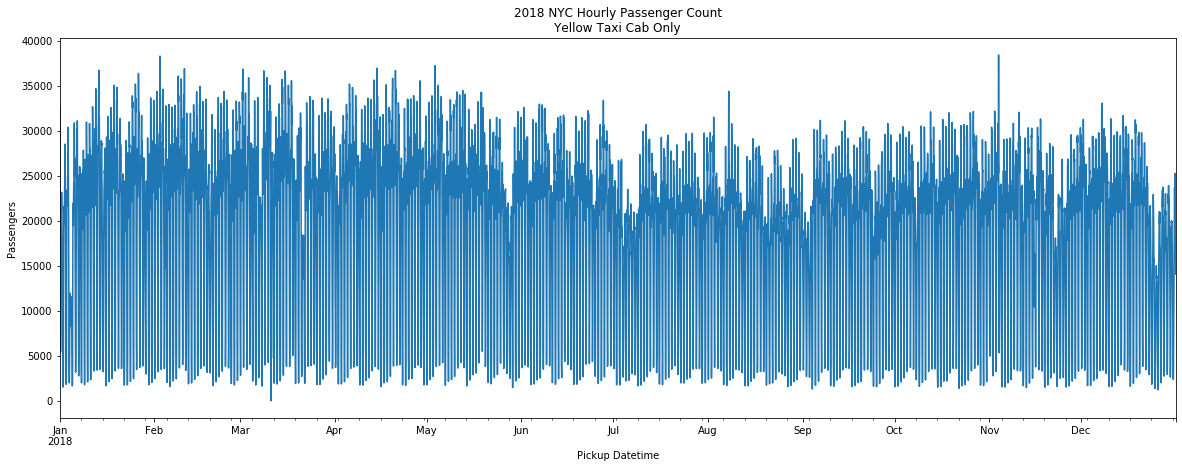

In [7]:
df.plot(figsize=(20,7), legend=None, title='2018 NYC Hourly Passenger Count\nYellow Taxi Cab Only')
plt.xlabel('Pickup Datetime')
plt.ylabel('Passengers')
plt.show()

In [26]:
windows = [
    ('Daily', 24),
    ('Half-Day', 12),
    ('Weekly', 7 * 24),
    ('Monthly', 30 * 24),
]

for label, window_size in windows:
    mp, mpi = stomp(df['passenger_count'].values, window_size)
    df['{} Profile'.format(label)] = np.append(mp, np.zeros(window_size - 1) + np.nan)

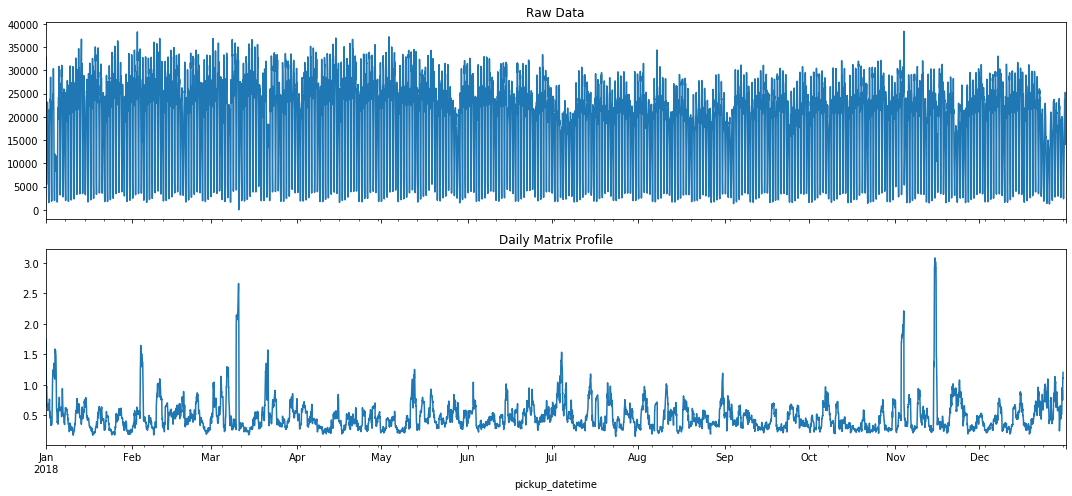

In [32]:
#Plot the signal data
fig, axes = plt.subplots(2,1,sharex=True,figsize=(15,7))
df['passenger_count'].plot(ax=axes[0], title='Raw Data')

#Plot the Matrix Profiles
df['Daily Profile'].plot(ax=axes[1], title='Daily Matrix Profile')
plt.tight_layout()
plt.show()

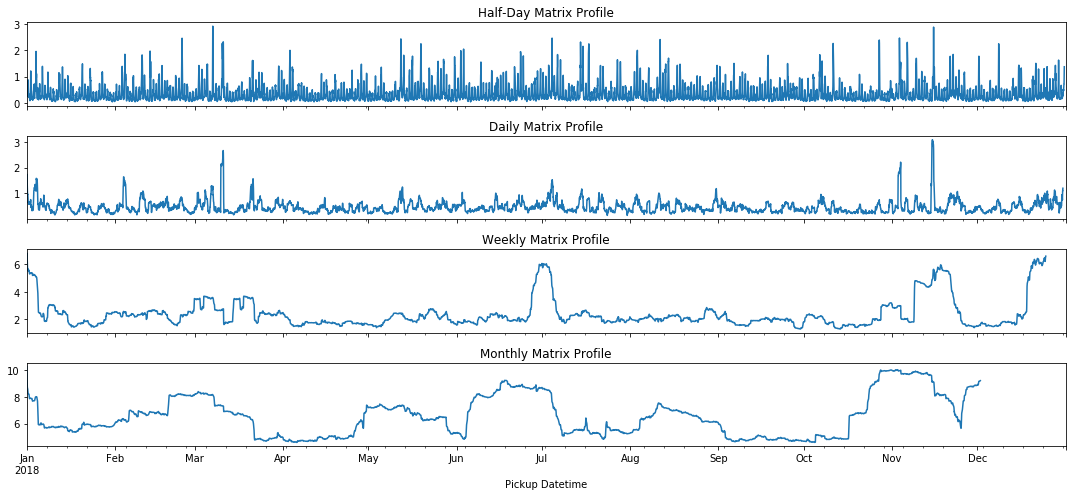

In [31]:
#Plot the signal data
fig, axes = plt.subplots(4,1,sharex=True,figsize=(15,7))

df['Half-Day Profile'].plot(ax=axes[0], title='Half-Day Matrix Profile')
df['Daily Profile'].plot(ax=axes[1], title='Daily Matrix Profile')
df['Weekly Profile'].plot(ax=axes[2], title='Weekly Matrix Profile')
df['Monthly Profile'].plot(ax=axes[3], title='Monthly Matrix Profile')
plt.xlabel('Pickup Datetime')
plt.tight_layout()
plt.show()